# Person Re-ID

## Importing

In [11]:
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import time
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import scipy.io

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import List, Tuple

## Runtime settings

In [3]:
import warnings
import wandb

!pip install -q wandb
!wandb login

os.environ["WANDB_API_KEY"] = "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"
#wandb.login(key=os.environ["WANDB_API_KEY"])

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [10]:
device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available.")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings.")

All good, a GPU is available.


## Reproducibility & deterministic mode

In [9]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 42
fix_random(seed=seed)

## Data loading and train/val/test split

In [12]:
import scipy.io
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, List, Set
from torch.utils.data import Dataset
from torchvision.transforms import functional as FT

class PRW_dataset(Dataset):
    @staticmethod
    def _load_mat_list(mat_path: Path, key: str):
        d = scipy.io.loadmat(mat_path)
        if key not in d:
            raise KeyError(f"Key '{key}' not found in {mat_path}. Keys: {list(d.keys())}")
        arr = d[key]
        return [x[0].item() for x in arr]  # e.g. 'c1s1_000151'

    @classmethod
    def find_train_test_data(cls, frames_path: Path, train_frames_path: Path, test_frames_path: Path):
        frames = [p.stem for p in sorted(frames_path.glob("*.jpg"))]  # 'c1s1_000151'
        frames_set = set(frames)

        train_names = cls._load_mat_list(train_frames_path, "img_index_train")
        test_names  = cls._load_mat_list(test_frames_path,  "img_index_test")

        train_set = set(train_names)
        test_set  = set(test_names)

        list_train_frames = [f for f in frames if f in train_set]
        list_test_frames  = [f for f in frames if f in test_set]

        if len(list_train_frames) != len(train_names):
            missing = [n for n in train_names if n not in frames_set]
            raise AssertionError(f"Train mismatch: matched={len(list_train_frames)} vs mat={len(train_names)}. Missing (first 10): {missing[:10]}")
        if len(list_test_frames) != len(test_names):
            missing = [n for n in test_names if n not in frames_set]
            raise AssertionError(f"Test mismatch: matched={len(list_test_frames)} vs mat={len(test_names)}. Missing (first 10): {missing[:10]}")

        return list_train_frames, list_test_frames

    def __init__(
        self,
        frames_path: Path,
        path_annotations: Path,
        train_frames_path: Path,
        test_frames_path: Path,
        split: str = "train",
        img_transform=None,
        filter_invalid_ids: bool = False,   # if True: keep only ids > 0
        allowed_pids: Optional[Set[int]] = None,  # keep only these IDs (positive ids)
        drop_empty: bool = False,           # if True: drop images that have zero boxes after filtering
    ):
        self.img_transform = img_transform
        self.filter_invalid_ids = filter_invalid_ids
        self.allowed_pids = allowed_pids
        self.drop_empty = drop_empty

        split = split.lower()
        if split not in {"train", "test"}:
            raise ValueError("split must be 'train' or 'test'")

        train_frames, test_frames = self.find_train_test_data(frames_path, train_frames_path, test_frames_path)
        allowed_frames = set(train_frames if split == "train" else test_frames)

        self.images = [p for p in sorted(frames_path.glob("*.jpg")) if p.stem in allowed_frames]

        # annotations are named like: c1s1_002876.jpg.mat
        annots = {p.stem: p for p in path_annotations.rglob("*.mat")}  # key: 'c1s1_002876.jpg'

        # building tuples (img, bbox)
        pairs = []
        for img_path in self.images:
            ann_key = img_path.name  # e.g. 'c1s1_002876.jpg'
            ann_path = annots.get(ann_key)
            if ann_path is None:
                raise RuntimeError(f"Missing annotation for frame {img_path.name}")
            pairs.append((img_path, ann_path))

        # pre-loading .mat files for bboxes
        self.box_cache = {}
        for img_path, ann_path in pairs:
            mat = scipy.io.loadmat(ann_path)
            arr = mat.get("box_new", mat.get("anno_file", mat.get("box", None)))

            if arr is None:
                boxes = np.zeros((0, 4), np.float32)
                ids   = np.zeros((0,), np.int64)
            else:
                arr = np.asarray(arr).reshape(-1, 5)
                ids = arr[:, 0].astype(np.int64)
                x = arr[:, 1].astype(np.float32)
                y = arr[:, 2].astype(np.float32)
                w = arr[:, 3].astype(np.float32)
                h = arr[:, 4].astype(np.float32)
                boxes = np.stack([x, y, x + w, y + h], axis=1).astype(np.float32)

            self.box_cache[str(ann_path)] = (boxes, ids)

        # Now build self.pairs, optionally filtering boxes by allowed IDs and dropping empty images
        self.pairs = []
        for img_path, ann_path in pairs:
            boxes_np, ids_np = self.box_cache[str(ann_path)]

            # filter invalid ids (e.g. -2 distractors, 0 background)
            if self.filter_invalid_ids:
                keep = ids_np > 0
                boxes_np = boxes_np[keep]
                ids_np = ids_np[keep]

            # filter by allowed_pids (ID-disjoint train/val)
            if self.allowed_pids is not None:
                keep = np.isin(ids_np, np.array(list(self.allowed_pids), dtype=np.int64))
                boxes_np = boxes_np[keep]
                ids_np = ids_np[keep]

            # update cache (filtered view)
            self.box_cache[str(ann_path)] = (boxes_np, ids_np)

            if self.drop_empty and boxes_np.shape[0] == 0:
                continue

            self.pairs.append((img_path, ann_path))

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, Any]]:
        img_path, ann_path = self.pairs[idx]

        img = Image.open(img_path).convert("RGB")
        boxes_np, ids_np = self.box_cache[str(ann_path)]

        target = {
            "boxes": torch.as_tensor(boxes_np, dtype=torch.float32),
            "labels": torch.ones((boxes_np.shape[0],), dtype=torch.int64),
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "person_id": torch.as_tensor(ids_np, dtype=torch.int64),
        }

        if self.img_transform is not None:
            img = self.img_transform(img)
        if not torch.is_tensor(img):
            img = FT.to_tensor(img)

        return img, target

    def __len__(self) -> int:
        return len(self.pairs)

    def unique_positive_pids(self) -> Set[int]:
        """Collect unique IDs > 0 present in this dataset view (after any filtering)."""
        s = set()
        for _, ann_path in self.pairs:
            _, ids_np = self.box_cache[str(ann_path)]
            for pid in ids_np.tolist():
                if pid > 0:
                    s.add(int(pid))
        return s


def make_id_disjoint_train_val(
    trainval_ds: PRW_dataset,
    val_ratio: float = 0.15,
    seed: int = 42,
    ensure_disjoint_from_test: Optional[PRW_dataset] = None,
):
    """
    Split TRAIN IDs into train/val (ID-disjoint).
    Remove IDs that appear in test split (strict disjoint across train/val/test).
    """
    rng = np.random.default_rng(seed)

    train_ids = sorted(list(trainval_ds.unique_positive_pids()))

    if ensure_disjoint_from_test is not None:
        test_ids = ensure_disjoint_from_test.unique_positive_pids()
        # remove any overlap with test (strict setting)
        train_ids = [pid for pid in train_ids if pid not in test_ids]

    train_ids = np.array(train_ids, dtype=np.int64)
    rng.shuffle(train_ids)

    n_val = int(round(len(train_ids) * val_ratio))
    val_ids = set(map(int, train_ids[:n_val].tolist()))
    trn_ids = set(map(int, train_ids[n_val:].tolist()))

    # sanity: disjoint
    assert val_ids.isdisjoint(trn_ids), "Train/Val ID sets overlap! Bug in split."
    if ensure_disjoint_from_test is not None:
        test_ids = ensure_disjoint_from_test.unique_positive_pids()
        assert val_ids.isdisjoint(test_ids), "Val overlaps with test IDs!"
        assert trn_ids.isdisjoint(test_ids), "Train overlaps with test IDs!"

    # build dataset views
    train_ds = PRW_dataset(
        frames_path=trainval_ds.images[0].parent,  # hack-safe? better pass original path 
        path_annotations=Path(str(trainval_ds.pairs[0][1])).parents[0],  # not ideal; 
        train_frames_path=None, # not needed since we already have the filtered pairs
        test_frames_path=None,
    )
    raise NotImplementedError("See the note below for clean construction.")


def build_train_val_views(
    frames_path: Path,
    path_annotations: Path,
    train_frames_mat: Path,
    test_frames_mat: Path,
    img_transform=None,
    filter_invalid_ids: bool = True,
    val_ratio: float = 0.15,
    seed: int = 42,
    strict_disjoint_from_test: bool = True,
):
    # base datasets
    trainval = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=None,
        drop_empty=False,
    )

    test = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="test",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=None,
        drop_empty=False,
    )

    train_ids = sorted(list(trainval.unique_positive_pids()))
    test_ids = test.unique_positive_pids()

    if strict_disjoint_from_test:
        train_ids = [pid for pid in train_ids if pid not in test_ids]

    rng = np.random.default_rng(seed)
    train_ids = np.array(train_ids, dtype=np.int64)
    rng.shuffle(train_ids)

    n_val = int(round(len(train_ids) * val_ratio))
    val_ids = set(map(int, train_ids[:n_val].tolist()))
    trn_ids = set(map(int, train_ids[n_val:].tolist()))

    assert val_ids.isdisjoint(trn_ids)

    if strict_disjoint_from_test:
        assert val_ids.isdisjoint(test_ids)
        assert trn_ids.isdisjoint(test_ids)

    # views: keep only boxes whose person_id is in the allowed set, drop images with no boxes
    train_view = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=trn_ids,
        drop_empty=True,
    )

    val_view = PRW_dataset(
        frames_path=frames_path,
        path_annotations=path_annotations,
        train_frames_path=train_frames_mat,
        test_frames_path=test_frames_mat,
        split="train",
        img_transform=img_transform,
        filter_invalid_ids=filter_invalid_ids,
        allowed_pids=val_ids,
        drop_empty=True,
    )

    return train_view, val_view, test, trn_ids, val_ids

In [14]:
# Loading data
path_imgs = Path("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frames")
path_annot = Path("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/annotations")
train_frames_mat = Path("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frame_train.mat")
test_frames_mat = Path("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frame_test.mat")

In [15]:
# 1) FULL train for detection (100% frame_train.mat, no ID filtering)
det_train_ds = PRW_dataset(
    frames_path=path_imgs,
    path_annotations=path_annot,
    train_frames_path=train_frames_mat,
    test_frames_path=test_frames_mat,
    split="train",
    img_transform=None,
    filter_invalid_ids=False,   # detection: keep -2
    allowed_pids=None,          
    drop_empty=False,
)

# 2) ReID train/val + test (ID-disjoint)
train_view, val_view, test_ds, train_ids, val_ids = build_train_val_views(
    frames_path=path_imgs,
    path_annotations=path_annot,
    train_frames_mat=train_frames_mat,
    test_frames_mat=test_frames_mat,
    img_transform=None,
    filter_invalid_ids=True,    # ignore -2 for re-id
    val_ratio=0.15,
    seed=42,
    strict_disjoint_from_test=True,
)

print("DET train images:", len(det_train_ds))
print("ReID train images:", len(train_view), "ReID val images:", len(val_view))
print("Test images:", len(test_ds))
print("ReID Train IDs:", len(train_ids), "ReID Val IDs:", len(val_ids))

DET train images: 5704
ReID train images: 4863 ReID val images: 1551
Test images: 6112
ReID Train IDs: 331 ReID Val IDs: 58


In [16]:
def collate_fn(batch):
    # https://discuss.pytorch.org/t/dataloader-gives-stack-expects-each-tensor-to-be-equal-size-due-to-different-image-has-different-objects-number/91941/4
    return tuple(zip(*batch)) #unpacks the batch and groups the individual elements together based on their position.
    #this is useful for datasets where each item contains multiple outputs (e.g., image and targets) of varying sizes.

num_workers = 4
batch_size = 2

data_loader_train = DataLoader(
    det_train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    collate_fn=collate_fn
)

data_loader_test = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    collate_fn=collate_fn
)

## Proposed strategy: Two-step person search
We will treat detection and re-id as two distinct tasks.

## Detecting with Faster-RCNN

In [17]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.amp import GradScaler, autocast

### Detection of bounding boxes

In [ ]:
# init model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)

# load weights
ckpt_path = "/kaggle/input/fasterrcnn-resnet50-fpn/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
state_dict = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)

num_classes = 2 # bg + person
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.transform.min_size = (600,)  # instead of default 800
model.transform.max_size = 1000    # instead of default 1333
model.to(device)

# init hyperparams
n_epochs = 5
lr = 0.005

# init optimizer
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=lr, momentum=0.9, weight_decay=0.0005
)

# Logging
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where project will be logged 
    entity="unibo-ai",
    # Set the wandb project where this run will be logged.
    project="person re-id",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": lr,
        "architecture": "FasterRCNN",
        "dataset": "PRW",
        "epochs": n_epochs,
    },
    name=f"fasterrcnn_r50fpn_fs_{int(time.time())}",
    reinit=True
)

# train loop
scaler = torch.amp.GradScaler("cuda", enabled=torch.cuda.is_available())
global_step = 0
model.train()
for epoch in range(n_epochs):
    running = 0.0

    for images, targets in data_loader_train:
        images  = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=torch.cuda.is_available()):
            loss_dict = model(images, targets)
            losses = sum(loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_val = losses.detach().item()
        running += loss_val

        # log per-step
        log = {"train/loss_total": loss_val, "epoch": epoch, "step": global_step}
        for k, v in loss_dict.items():
            log[f"train/{k}"] = v.detach().item()
        log["train/lr"] = optimizer.param_groups[0]["lr"]

        wandb.log(log, step=global_step)
        global_step += 1

    wandb.log({"train/epoch_loss_avg": running/len(data_loader_train), "epoch": epoch}, step=global_step)
    print(f"Epoch {epoch} avg loss: {running/len(data_loader_train):.4f}")

ckpt = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scaler": scaler.state_dict(),
}
torch.save(ckpt, "ckpt.pth")

artifact = wandb.Artifact("fasterrcnn_ckpt", type="model")
artifact.add_file("ckpt.pth")
wandb.log_artifact(artifact)

wandb: Currently logged in as: tommaso-perniola (unibo-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 0 avg loss: 0.2205
Epoch 1 avg loss: 0.1847
Epoch 2 avg loss: 0.1665
Epoch 3 avg loss: 0.1541
Epoch 4 avg loss: 0.1449


<Artifact fasterrcnn_ckpt>

### Loading weights

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = "cuda" if torch.cuda.is_available() else "cpu"
weights_path = "/kaggle/input/detection-weights/det_fasterrcnn.pth"

# 1) build model (no weights)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=None, weights_backbone=None
)

# 2) set SAME head as in checkpoint (2 classes)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3) load
ckpt = torch.load(weights_path, map_location="cpu")
model.load_state_dict(ckpt["model"])
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

### Eval & visualize predicted bboxes

In [20]:
from torchvision.transforms.functional import to_pil_image
from PIL import ImageDraw

def draw_bboxes(img_tensor, boxes, scores=None, thr=0.5, topk=20, width=3):
    '''
    Viz. function to plot bboxes around predictions.
    '''
    img = to_pil_image(img_tensor.detach().cpu())
    draw = ImageDraw.Draw(img)

    boxes = boxes.detach().cpu()
    if scores is not None:
        scores = scores.detach().cpu()
        keep = scores >= thr
        boxes = boxes[keep]
        scores = scores[keep]
        if topk is not None and len(scores) > topk:
            idx = scores.argsort(descending=True)[:topk]
            boxes = boxes[idx]
            scores = scores[idx]

    for i, (x1,y1,x2,y2) in enumerate(boxes.tolist()):
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=width)

    return img

[Image 1]
  #bboxes predicted: 5
  #bboxes w/ score > 0.5: 3
[Image 2]
  #bboxes predicted: 8
  #bboxes w/ score > 0.5: 6
[Image 3]
  #bboxes predicted: 6
  #bboxes w/ score > 0.5: 6


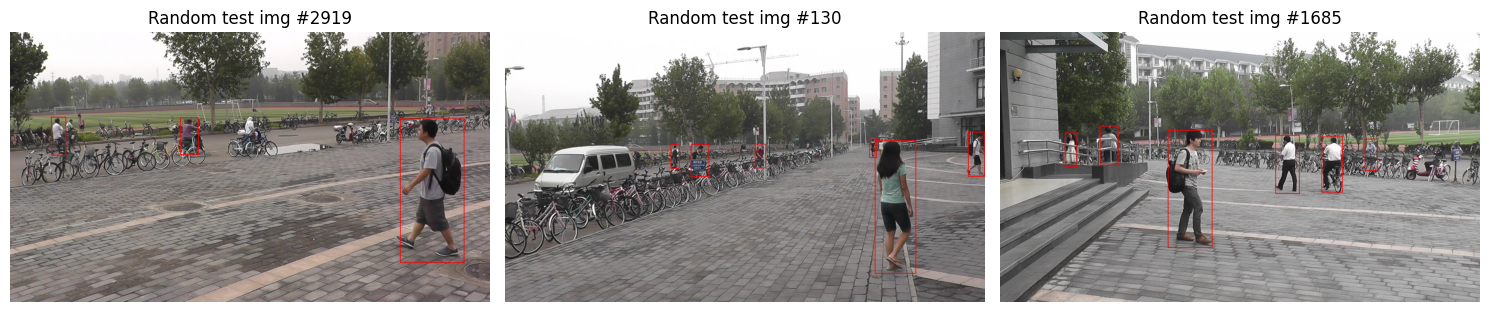

In [26]:
# INFERENCE MODE
model = model.to(device).eval()

n_samples = 3
thresh = 0.5

plt.figure(figsize=(15, 6))

# 3 random images
for i in range(n_samples):
    # random index
    idx = np.random.randint(len(test_ds))
    img = test_ds[idx][0].to(device)

    with torch.no_grad():
        pred = model([img])[0]

    boxes  = pred["boxes"]
    scores = pred["scores"]

    keep = scores > thresh

    print(f"[Image {i+1}]")
    print(f"  #bboxes predicted: {len(boxes)}")
    print(f"  #bboxes w/ score > {thresh}: {keep.sum().item()}")

    img_drawn = draw_bboxes(
        img_tensor=img,
        boxes=boxes[keep],
        scores=scores[keep],
        thr=0.0,
        topk=None
    )

    plt.subplot(1, n_samples, i + 1)
    plt.imshow(img_drawn)
    plt.title(f"Random test img #{idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

> Detection works quite well: the model is able to predict most of the g.t. person bboxes with a high accuracy

### Metrics

In [ ]:
@torch.no_grad() # just inference, no gradient flowing
def build_dets_by_index(model, dataset, device, score_thresh=0.2, max_det=200):
    '''
    Function to compute predictions for the given set (e.g. test set)
    '''
    model.eval()
    out = [] # list of predictions for each img
    for i in range(len(dataset)):
        img, _ = dataset[i]
        img = img.to(device)
        pred = model([img])[0]
        boxes, scores = pred["boxes"], pred["scores"]
        keep = scores >= score_thresh # keep only above thresh
        boxes, scores = boxes[keep], scores[keep]
        if max_det is not None and boxes.shape[0] > max_det: # num. detections
            idx = scores.argsort(descending=True)[:max_det] # keep only the first max_det detections
            boxes, scores = boxes[idx], scores[idx] # selecting them
        det = torch.cat([boxes, scores[:,None]], 1).cpu().numpy().astype(np.float32) # concat.
        out.append(det) # append predicted bboxes to each image
    return out

# compute test predictions
test_detections = build_dets_by_index(model,  test_ds,      device, score_thresh=0.2)
train_detections = build_dets_by_index(model, det_train_ds, device, score_thresh=0.2)

In [47]:
# save test_detections
with open("test_preds.pkl", "wb") as fp:
    pickle.dump(test_detections, fp)

with open("train_preds.pkl", "wb") as fp:
    pickle.dump(train_detections, fp)

In [12]:
# load predictions
with open("/kaggle/input/detection-weights/test_preds.pkl", "rb") as fp:
    test_detections = pickle.load(fp)

# load predictions
with open("/kaggle/input/detection-weights/train_preds.pkl", "rb") as fp:
    train_detections = pickle.load(fp)

In [13]:
# sanity check
num_detections = [test_detections[i].shape[0] for i in range(len(test_detections))]
print(f"Total test detections: {len(test_detections)}")  # should be len(test_ds)
print("Per-img")
print("- min num_det:", min(num_detections))
print("- mean num_det:", int(sum(num_detections) / len(num_detections)))
print("- max num_det:", max(num_detections))

# sanity check
num_detections = [train_detections[i].shape[0] for i in range(len(train_detections))]
print(f"\nTotal val detections: {len(train_detections)}")  # should be len(test_ds)
print("Per-img")
print("- min num_det:", min(num_detections))
print("- mean num_det:", int(sum(num_detections) / len(num_detections)))
print("- max num_det:", max(num_detections))

Total test detections: 6112
Per-img
- min num_det: 1
- mean num_det: 5
- max num_det: 23

Total val detections: 5704
Per-img
- min num_det: 1
- mean num_det: 3
- max num_det: 14


In [39]:
def compute_ap_voc(recall, precision):
    """
    VOC2010+ style AP:
    - add sentinel endpoints
    - build precision envelope
    - integrate area under PR curve
    """
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # precision envelope
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    # integrate where recall changes
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return float(ap)

def _compute_iou_xyxy(a, b):
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])
    inter = max(0.0, x2 - x1) * max(0.0, y2 - y1)
    area_a = max(0.0, a[2] - a[0]) * max(0.0, a[3] - a[1])
    area_b = max(0.0, b[2] - b[0]) * max(0.0, b[3] - b[1])
    union = area_a + area_b - inter
    return 0.0 if union <= 0 else inter / union

def eval_detection_prw_canonical_ap(
    dataset,
    dets,                      # list len N, each (M,5) [x1,y1,x2,y2,score]
    det_thresh=0.0,
    iou_thresholds=(0.5,),
    include_distractors=True,
):
    assert len(dataset) == len(dets)

    # --- cache GT per image ---
    gt_boxes_per_img = []
    n_gt_total = 0
    for i in range(len(dataset)):
        _, tgt = dataset[i]
        gt = tgt["boxes"].detach().cpu().numpy().astype(np.float32).reshape(-1, 4)

        if not include_distractors and "person_id" in tgt:
            pid = tgt["person_id"].detach().cpu().numpy()
            gt = gt[pid > 0]

        gt_boxes_per_img.append(gt)
        n_gt_total += len(gt)

    results = {"n_gt": int(n_gt_total), "per_iou": {}}

    # --- collect detections globally ---
    # each entry: (score, img_idx, box[4])
    all_dets = []
    for img_idx in range(len(dataset)):
        det = np.asarray(dets[img_idx], dtype=np.float32).reshape(-1, 5)
        if det.size == 0:
            continue
        keep = det[:, 4] >= det_thresh
        det = det[keep]
        for d in det:
            all_dets.append((float(d[4]), img_idx, d[:4].astype(np.float32)))

    # sort once globally 
    all_dets.sort(key=lambda x: x[0], reverse=True)

    for iou_t in iou_thresholds:
        if n_gt_total == 0:
            results["per_iou"][float(iou_t)] = {
                "AP": 0.0, "precision": 0.0, "recall": 0.0,
                "tp": 0, "fp": 0
            }
            continue

        # matched flags per GT, per image
        matched = [np.zeros(len(gt_boxes_per_img[i]), dtype=bool) for i in range(len(dataset))]

        tp = np.zeros(len(all_dets), dtype=np.int32)
        fp = np.zeros(len(all_dets), dtype=np.int32)

        for k, (score, img_idx, box_d) in enumerate(all_dets):
            gt = gt_boxes_per_img[img_idx]
            if len(gt) == 0:
                fp[k] = 1
                continue

            # find best unmatched GT in this image
            best_iou = 0.0
            best_j = -1
            for j in range(len(gt)):
                if matched[img_idx][j]:
                    continue
                iou = _compute_iou_xyxy(box_d, gt[j])
                if iou > best_iou:
                    best_iou = iou
                    best_j = j

            if best_iou >= iou_t and best_j >= 0:
                tp[k] = 1
                matched[img_idx][best_j] = True
            else:
                fp[k] = 1

        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)

        recall = tp_cum / float(n_gt_total)
        precision = tp_cum / np.maximum(1.0, (tp_cum + fp_cum))

        ap = compute_ap_voc(recall, precision)

        results["per_iou"][float(iou_t)] = {
            "AP": float(ap),
            "precision": float(precision[-1]) if len(precision) else 0.0,
            "recall": float(recall[-1]) if len(recall) else 0.0,
            "tp": int(tp_cum[-1]) if len(tp_cum) else 0,
            "fp": int(fp_cum[-1]) if len(fp_cum) else 0,
            "n_det": int(len(all_dets)),
        }

    aps = [results["per_iou"][t]["AP"] for t in results["per_iou"]]
    results["mAP"] = float(np.mean(aps)) if len(aps) else 0.0
    return results

In [40]:
# run metrics
det_metrics = eval_detection_prw_canonical_ap(
    dataset=test_ds,
    dets=test_detections,
    det_thresh=0.05,
    iou_thresholds=(0.5, 0.75),
    include_distractors=True
)
print(det_metrics)

{'n_gt': 19116, 'per_iou': {0.5: {'AP': 0.8611808478487347, 'precision': 0.586312146003776, 'recall': 0.9747332077840553, 'tp': 18633, 'fp': 13147, 'n_det': 31780}, 0.75: {'AP': 0.7038271776584106, 'precision': 0.502863436123348, 'recall': 0.8360012554927809, 'tp': 15981, 'fp': 15799, 'n_det': 31780}}, 'mAP': 0.7825040127535727}


> The detector achieves strong performance. In particular, since the goal of person search is not to miss potential identities, **recall** is the most critical metric: we prefer to retain more candidate detections, even at the cost of additional false positives, which can later be filtered by the Re-ID stage.
> 
> Considering the standard IoU threshold of 0.5, the model reaches a recall of 0.97, meaning that nearly all ground-truth pedestrians are successfully detected. This high recall ensures that the subsequent re-identification module operates on a sufficiently complete set of candidate regions.